# Load data

In [33]:
import pandas as pd

data_fraud = pd.read_csv('../data/data_fraud_final.csv')

In [34]:
data_fraud.head()

,D1,D4,D5,D6,D8,D10,D13,D15,V12,V30,...,M6_nan,M9_T,id_12_NotFound,id_31_chrome 64.0 for android,id_31_chrome generic,id_37_T,DeviceType_mobile,DeviceInfo_SM-A300H Build/LRX22G,DeviceInfo_hi6210sft Build/MRA58K,isFraud
0,14.0,88.931389,29.908723,30.726991,177.131369,13.000000,-5.365878,0.000000,1.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,47.168517,56.969919,174.583114,0.000000,2.900229,0.000000,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,33.781705,34.646134,178.268862,0.000000,-3.856653,315.000000,1.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,112.0,94.000000,0.000000,12.142125,181.177056,84.000000,-7.359038,111.000000,1.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,245.284719,45.761553,73.034183,136.044491,53.717295,24.006143,53.966745,0.04481,0.306017,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [35]:
from collections import Counter
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import train_test_split

data_fraud_sampled = data_fraud.sample(frac=1, random_state=42)

X, y = data_fraud_sampled.drop('isFraud', axis=1), data_fraud_sampled['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


ada = ADASYN(random_state=42)
X_train_res, y_train_res = ada.fit_resample(X_train, y_train)

print('Original train dataset shape {}'.format(Counter(y_train)))
print('Resampled train dataset shape {}'.format(Counter(y_train_res)))
print('Test dataset shape {}'.format(Counter(y_test)))

Original train dataset shape Counter({0.0: 455895, 1.0: 16537})
Resampled train dataset shape Counter({0.0: 455895, 1.0: 455405})
Test dataset shape Counter({0.0: 113982, 1.0: 4126})


# Training

## Without hyperparametrization

In [36]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

dict_models = {
    'Naive Bayes': BernoulliNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=50),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42, n_estimators=50),
    'K-NN': KNeighborsClassifier(),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=500)
}

In [37]:
from utils import model_evaluation_clf
from time import time
from copy import deepcopy

import warnings
warnings.filterwarnings("ignore")

results = pd.DataFrame(columns=["Model", "Accuracy", "Precision", "Recall", "f1-score", "AUC", "Training Time (s)"])
models = {}
models_res = {}


for i, model_name in enumerate(dict_models.keys()):
    print('Training', model_name, end=' => ')

    model = dict_models[model_name]
    model_res = deepcopy(model)

    start_time = time()
    model.fit(X_train, y_train)
    end_time = time()

    start_time_res = time()
    model_res.fit(X_train_res, y_train_res)
    end_time_res = time()

    models[model_name] = model
    models_res[model_name + ' (res)'] = model_res

    eval = model_evaluation_clf(model, X_test, y_test)
    eval_res = model_evaluation_clf(model_res, X_test, y_test)

    results.loc[2*i] = [model_name, eval['accuracy'], eval['precision'], eval['recall'], eval['f1'], eval['roc_auc'], round(end_time - start_time, 1)]
    results.loc[2*i+1] = [model_name + ' (res)', eval_res['accuracy'], eval_res['precision'], eval_res['recall'], eval_res['f1'], eval_res['roc_auc'], round(end_time_res - start_time_res, 1)]

    print(f"{round(sum([end_time - start_time, end_time_res - start_time_res]), 1)}s")

Training Naive Bayes => 1.6s
Training Decision Tree => 130.4s
Training Random Forest => 3403.0s
Training Gradient Boosting => 1057.6s
Training K-NN => 0.5s
Training Logistic Regression => 70.5s


In [38]:
results = results.sort_values(by='AUC', ascending=False)
print(results.to_string(index=False))

                    Model  Accuracy  Precision  Recall  f1-score   AUC  Training Time (s)
      Random Forest (res)     0.991      0.922   0.814     0.865 0.906             3218.5
               K-NN (res)     0.945      0.370   0.828     0.512 0.889                0.4
            Decision Tree     0.983      0.756   0.766     0.761 0.878               62.1
      Decision Tree (res)     0.979      0.668   0.769     0.715 0.878               68.3
            Random Forest     0.989      0.966   0.723     0.827 0.861              184.5
  Gradient Boosting (res)     0.920      0.258   0.690     0.375 0.809              730.4
                     K-NN     0.977      0.764   0.493     0.599 0.744                0.1
Logistic Regression (res)     0.783      0.101   0.660     0.176 0.724               44.0
        Naive Bayes (res)     0.751      0.078   0.565     0.137 0.661                1.1
              Naive Bayes     0.759      0.079   0.552     0.138 0.659                0.5
        Gr

## With hyperparametrization

We had better results with the resampled data. For the hyperparametrization we only considered the resampled dataset.

In [39]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

nb_col = X_train.shape[1]

dict_models = [
    {
        'name_clf' : 'K-NN',
        'model': KNeighborsClassifier(n_neighbors=1),
        'scalers' : {
            'scaler': [MinMaxScaler()], # After some tries, we found that the best scaler is MinMaxScaler
        },
        'grid' : {} # After some tries, we found that the best model is the one with n_neighbors=1
    },

    {
        'name_clf' : 'Gradient Boosting',
        'model': GradientBoostingClassifier(random_state=42, n_estimators=50, max_depth=5),
        'scalers' : {
            'scaler': [None],
        },
        'grid' : {}, # After some tries, we found that the best model is the one with max_depth=5

    },

    {
        'name_clf' : 'Naive Bayes',
        'model': BernoulliNB(),
        'scalers' : {
            'scaler' : [None, MinMaxScaler(), StandardScaler()],
        },
        'grid' : {
            'model__alpha': [10**k for k in range(-5, 6)],
        },
    },

    {
        'name_clf' : 'Logistic Regression',
        'model': LogisticRegression(random_state=42, max_iter=1000),
        'scalers' : {
            'scaler': [StandardScaler()],
        },
        'grid' : {
            'model__C': [0.1, 1, 10],
            'model__penalty': ['l1', 'l2'],
        },
    },

    {
        'name_clf' : 'Decision Tree',
        'model': DecisionTreeClassifier(random_state=42),
        'scalers' : {
            'scaler': [None],
        },
        'grid' : {
            'model__max_depth': list(range(1, nb_col + 1)),
        },
    },

    {
        'name_clf' : 'Random Forest',
        'model': RandomForestClassifier(random_state=42, n_estimators=50),
        'scalers' : {
            'scaler': [None],
        },
        'grid' : {
            'model__max_depth': list(range(1, nb_col + 1, 5)),
        },    
    },


]

The data is shuffled with the sample (frac=1) so we have eliminated every tendancy. Finding the best parameters alreday require a lot of time beacause of the high amount of data and the use of a cross validation is useless thanks to the shuffle. We choose not to use any cross validation.

In [40]:
from sklearn.pipeline import Pipeline
from skopt import BayesSearchCV
from sklearn.model_selection import GridSearchCV
from time import time
from utils import model_evaluation_clf
from copy import deepcopy

import warnings
warnings.filterwarnings("ignore")

results = pd.DataFrame(columns=["Model", "Accuracy", "Precision", "Recall", "f1-score", "AUC", "Training Time (s)"])
models_bayes = {}
models_gs = {}
nb_res = 0

for i, dict_clf in enumerate(dict_models):
    model_name_gs = dict_clf['name_clf']
    model_name_bayes = model_name_gs + ' (Bayes)'
    print(f'Training {model_name_gs}')

    model = dict_clf['model']

    steps_gs = [
        ('scaler', None),
        ('model', model),
    ]
    steps_bayes = [
        ('scaler', None),
        ('model', deepcopy(model)),
    ]
    pipeline_gs = Pipeline(steps_gs)
    pipeline_bayes = Pipeline(steps_bayes)

    param_grid = {
        **dict_clf['scalers'],
        **dict_clf['grid']
    }

    clf_gs = GridSearchCV(pipeline_gs, param_grid=param_grid, n_jobs=-1)
    clf_bayes = BayesSearchCV(pipeline_bayes, search_spaces=param_grid, n_jobs=-1, n_iter=10)

    start_time_gs = time()
    clf_gs.fit(X_train_res, y_train_res)
    end_time_gs = time()

    start_time_bayes = time()
    clf_bayes.fit(X_train_res, y_train_res)
    end_time_bayes = time()
    
    print(f"Best GridSearchCV params {model_name_gs}: \n{clf_gs.best_params_}")
    print(f"Best BayesSearchCV params {model_name_bayes}: \n{clf_bayes.best_params_}")

    eval_gs = model_evaluation_clf(clf_gs, X_test, y_test)
    eval_bayes = model_evaluation_clf(clf_bayes, X_test, y_test)
    
    models_gs[model_name_gs] = clf_gs
    models_bayes[model_name_bayes] = clf_bayes

    results.loc[nb_res] = [model_name_gs, eval_gs['accuracy'], eval_gs['precision'], eval_gs['recall'], eval_gs['f1'], eval_gs['roc_auc'], round(end_time_gs - start_time_gs, 1)]
    results.loc[nb_res+1] = [model_name_bayes, eval_bayes['accuracy'], eval_bayes['precision'], eval_bayes['recall'], eval_bayes['f1'], eval_bayes['roc_auc'], round(end_time_bayes - start_time_bayes, 1)]
    nb_res += 2

    print(f"Training time: {round(sum([end_time_gs - start_time_gs, end_time_bayes - start_time_bayes]), 1)}s")
    print()

Training K-NN


Best GridSearchCV params K-NN: 
{'scaler': MinMaxScaler()}
Best BayesSearchCV params K-NN (Bayes): 
OrderedDict([('scaler', MinMaxScaler())])
Training time: 22930.1s

Training Gradient Boosting
Best GridSearchCV params Gradient Boosting: 
{'scaler': None}
Best BayesSearchCV params Gradient Boosting (Bayes): 
OrderedDict([('scaler', None)])
Training time: 12746.2s

Training Naive Bayes
Best GridSearchCV params Naive Bayes: 
{'model__alpha': 1e-05, 'scaler': StandardScaler()}
Best BayesSearchCV params Naive Bayes (Bayes): 
OrderedDict([('model__alpha', 0.001), ('scaler', StandardScaler())])
Training time: 91.9s

Training Logistic Regression
Best GridSearchCV params Logistic Regression: 
{'model__C': 10, 'model__penalty': 'l2', 'scaler': StandardScaler()}
Best BayesSearchCV params Logistic Regression (Bayes): 
OrderedDict([('model__C', 10), ('model__penalty', 'l2'), ('scaler', StandardScaler())])
Training time: 119.9s

Training Decision Tree
Best GridSearchCV params Decision Tree: 
{'mode

In [41]:
results = results.sort_values(by='AUC', ascending=False)
print(results.to_string(index=False))

                      Model  Accuracy  Precision  Recall  f1-score   AUC  Training Time (s)
              Random Forest     0.991      0.914   0.816     0.862 0.906             1470.9
      Random Forest (Bayes)     0.991      0.914   0.816     0.862 0.906             4111.9
      Decision Tree (Bayes)     0.977      0.640   0.783     0.705 0.884              517.1
              Decision Tree     0.978      0.654   0.774     0.709 0.880             1299.6
          Gradient Boosting     0.951      0.398   0.762     0.523 0.860             2069.0
  Gradient Boosting (Bayes)     0.951      0.398   0.762     0.523 0.860            10677.3
                       K-NN     0.978      0.686   0.679     0.682 0.834             5475.4
               K-NN (Bayes)     0.978      0.686   0.679     0.682 0.834            17454.8
        Logistic Regression     0.850      0.141   0.651     0.232 0.754               28.6
Logistic Regression (Bayes)     0.850      0.141   0.651     0.232 0.754        

In general, BayesSearchCV take much more time to find the best parameters. This is because BayesSearchCV makes 10 tries for each model wheather we don't have more than 10 tries for GridSearchCV. Moreover, a lot of hyperparameters are int so we loose the main interest of BayesOptimization.

The scores with Bayes and with Gridseearch are almost the same so for the plot we will use the models hyperparametrized with GridSearch.

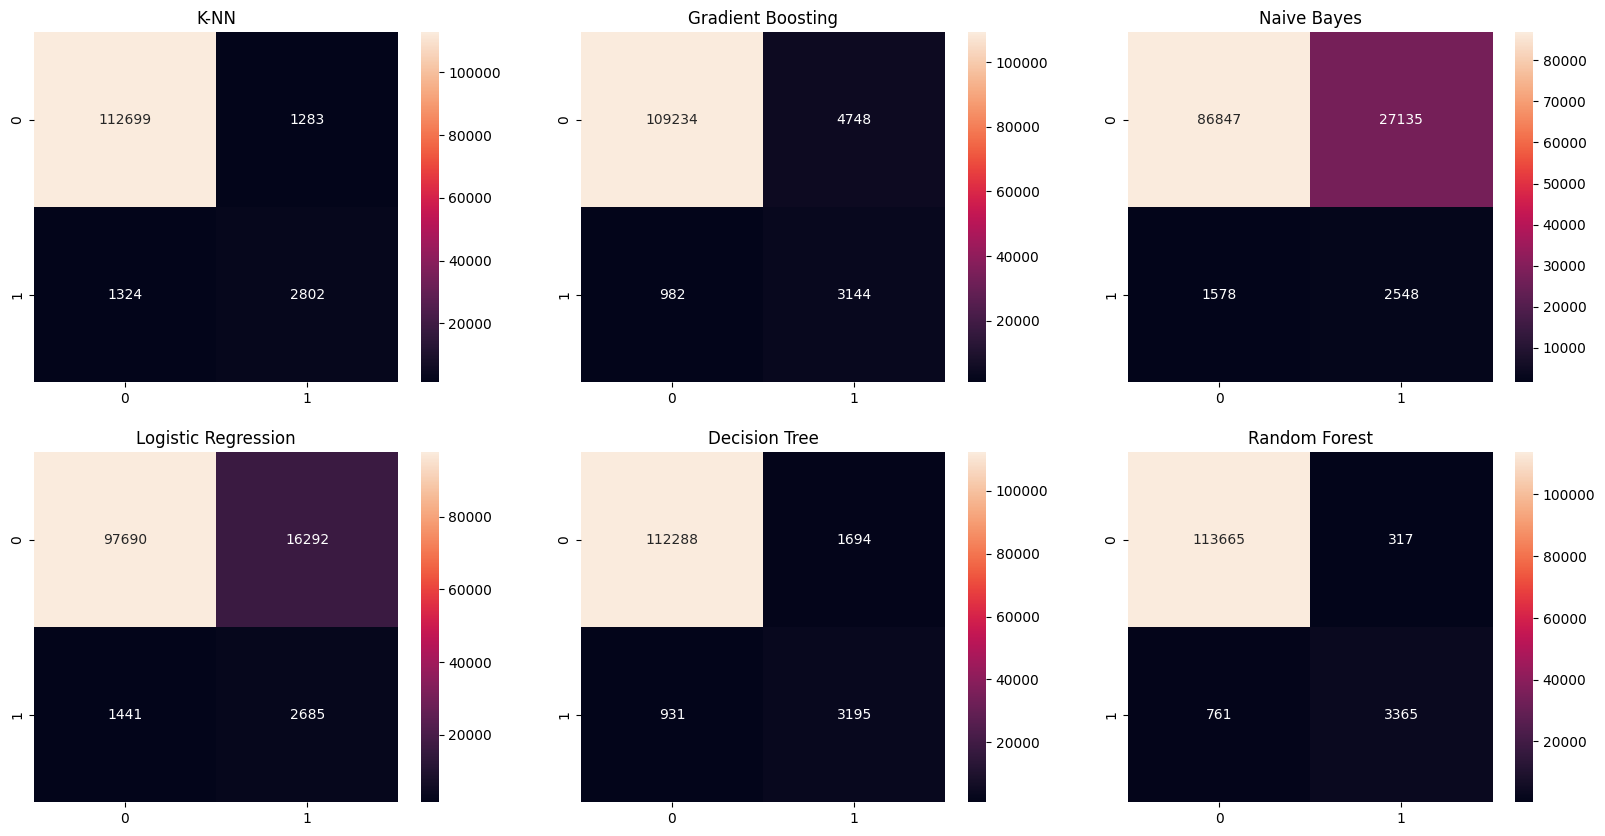

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

fig, axs = plt.subplots(2, 3, figsize=(20, 10))

for i, model_name in enumerate(models_gs.keys()):
    model = models_gs[model_name]
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', ax=axs[i//3, i%3])
    axs[i//3, i%3].set_title(model_name)


plt.show()

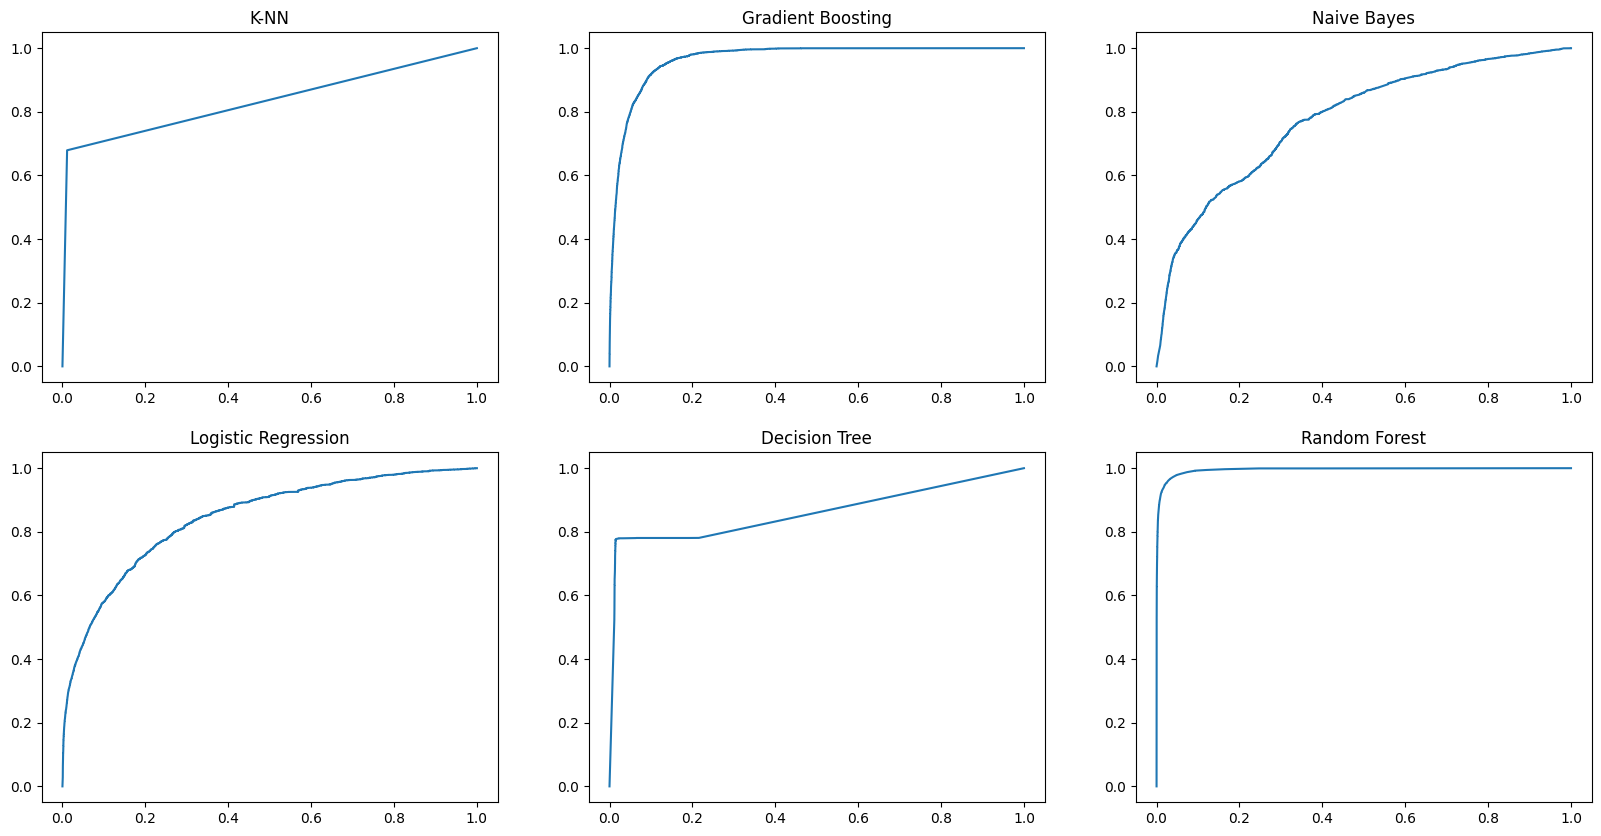

In [43]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

fig, axs = plt.subplots(2, 3, figsize=(20, 10))

for i, model_name in enumerate(models_gs.keys()):
    model = models_gs[model_name]
    y_pred = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    axs[i//3, i%3].plot(fpr, tpr)
    axs[i//3, i%3].set_title(model_name)

plt.show()

With these curves, we can see that random forest has the highest rate of true positive and lowest rate of false positive.

Finally, **Random** Forest has the best results (highest score for every metric). So we choose this model.